In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load data

In [2]:
recommendations = pd.read_csv("Suositukset.csv", parse_dates=[0])
recommendations['Indeksi'] = 'Lisää'

In [3]:
len(recommendations["Analyytikko"].unique())

17

In [4]:
# Calculate for each interval (PvmEdellinen, Pvm) the profit and holding time
def add_statistics(df_stock):
    df_stock['PvmEdellinen'] = df_stock['Pvm'].shift(1)
    df_stock['Tuotto'] = (df_stock['Osakekurssi']/df_stock['Osakekurssi'].shift(1)).fillna(1.00)
    df_stock['Pitoaika'] = (df_stock['Pvm']-df_stock['PvmEdellinen']).dt.days.fillna(0)
    df_stock['Salkussa'] = (df_stock['Suositus'].shift(1) == 'Lisää') | (df_stock['Suositus'].shift(1) == 'Osta')
    return(df_stock)
# Add info to each recommendation event
recommendations = recommendations.groupby('Osake').apply(add_statistics)

In [5]:
## Some have very short follow-up times, resulting in outlier IRRs, require at least 4 months (120 days) of follow-up
#follow_up = recommendations.groupby('Osake')['Pitoaika'].sum()
#take_stocks = follow_up.index[follow_up >= 120]
#recommendations = recommendations.loc[recommendations['Osake'].isin(take_stocks),].copy()

### Return between recommendations: Buy&Hold and Inderes

In [6]:
# Calculate for each interval the profit and holding time for a given strategy
def get_statistics(df_stock, key='Suositus'):
    salkussa = (df_stock[key].shift(1) == 'Lisää') | (df_stock[key].shift(1) == 'Osta')
    tuotto_salkussa = np.where(salkussa, df_stock['Tuotto'], 1.00).prod()
    pitoaika_salkussa = np.where(salkussa, df_stock['Pitoaika'], 0).sum()
    statistics = { # Aggregate over intervals
        'Tuotto': tuotto_salkussa,
        'Pitoaika': pitoaika_salkussa,
        'CAGR': tuotto_salkussa**(365/pitoaika_salkussa) if pitoaika_salkussa > 0 else 1.0
    }
    return(pd.Series(statistics))

In [7]:
# Calculate the geometric mean (CAGR) of a diversified stock portfolio from the arithmetic mean of holding the stocks, 
# given their total holding times when a recommendation was active (probability of exposure)
def geom_mean(cagr, exposure, n=1000):
    arit_avgs = []
    for b in range(n):
        holding = np.random.binomial(1, exposure)
        arit_avg = np.average(cagr, weights = holding) if holding.sum() > 0 else 1.0
        arit_avgs.append(arit_avg)
    geom_avg = np.exp(np.mean(np.log(arit_avgs)))
    return(geom_avg)

### Visualization

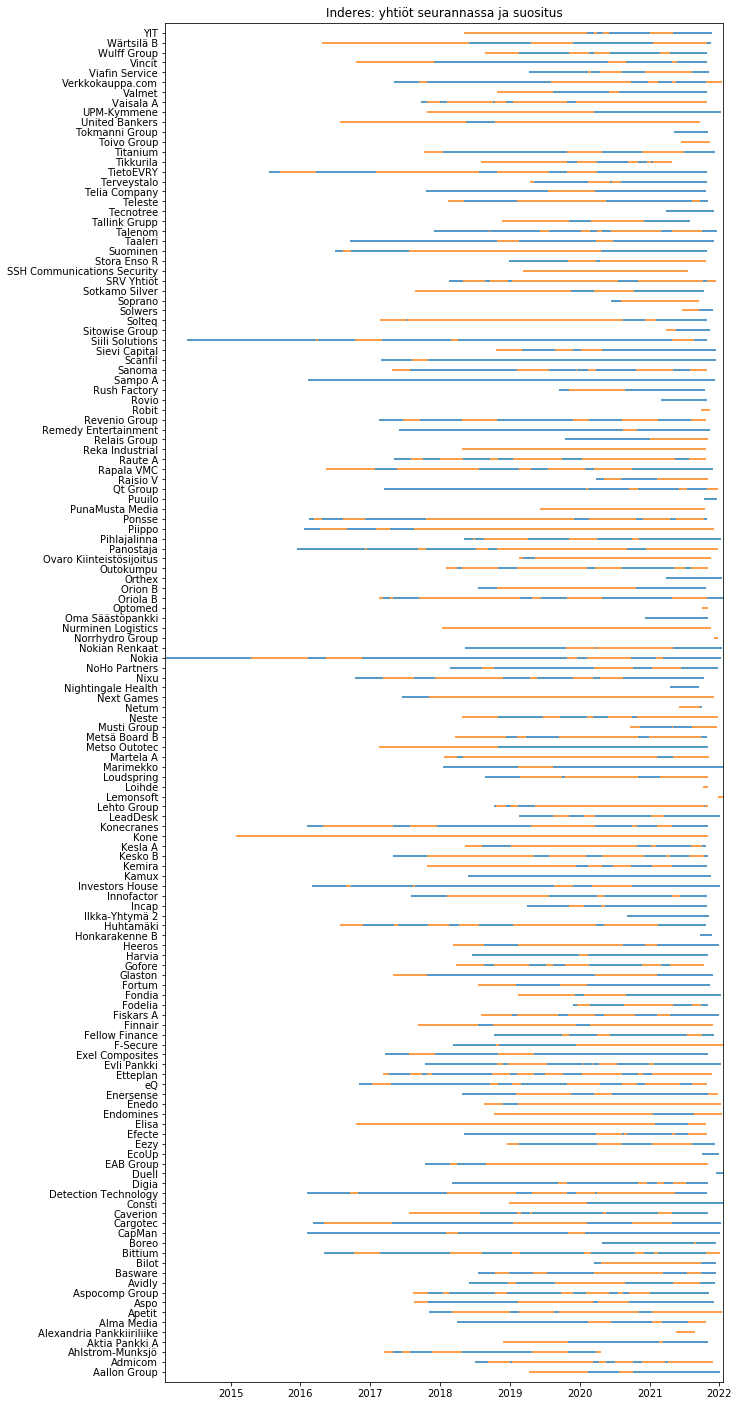

In [8]:
# Visualize Inderes follow-up and recommendation during it
temp = recommendations[~recommendations['PvmEdellinen'].isnull()].copy()
x1, x2 = temp['PvmEdellinen'], temp['Pvm']
cx = np.where(temp['Salkussa'], 'tab:blue', 'tab:orange')
fig, ax = plt.subplots(1,1, figsize=(10,25))
ax.hlines(y=temp['Osake'], xmin=x1, xmax=x2, color=cx)
ax.set_xlim(x1.min(), x2.max())
ax.set_ylim(-1, len(temp['Osake'].unique()))
ax.set_title('Inderes: yhtiöt seurannassa ja suositus')
plt.show()

### Nokia example

In [9]:
df_stock = recommendations[recommendations['Osake'] == 'Nokia'].copy()
df_stock['Analyytikko'] = df_stock['Analyytikko'].map({'Atte Riikola': 'Mikael Rautanen'})
df_stock[10:20]

,Pvm,Suositus,Tavoite,Osakekurssi,Analyytikko,Osake,Indeksi,PvmEdellinen,Tuotto,Pitoaika,Salkussa
1706,2015-10-30,Vähennä,6.4,6.70,Mikael Rautanen,Nokia,Lisää,2015-07-31,1.041991,91.0,False
1707,2016-02-10,Lisää,5.8,5.19,Mikael Rautanen,Nokia,Lisää,2015-10-30,0.774627,103.0,False
1708,2016-05-11,Vähennä,4.6,4.65,Mikael Rautanen,Nokia,Lisää,2016-02-10,0.895954,91.0,True
1709,2016-08-05,Vähennä,4.6,4.90,Mikael Rautanen,Nokia,Lisää,2016-05-11,1.053763,86.0,False
1710,2016-10-27,Vähennä,4.3,4.32,Mikael Rautanen,Nokia,Lisää,2016-08-05,0.881633,83.0,False
1711,2016-11-16,Lisää,4.3,3.81,Mikael Rautanen,Nokia,Lisää,2016-10-27,0.881944,20.0,False
1712,2017-01-09,Lisää,4.8,4.58,Mikael Rautanen,Nokia,Lisää,2016-11-16,1.202100,54.0,True
1713,2017-02-02,Lisää,5.0,4.45,Mikael Rautanen,Nokia,Lisää,2017-01-09,0.971616,24.0,True
1714,2017-03-16,Lisää,5.4,5.00,Mikael Rautanen,Nokia,Lisää,2017-02-02,1.123596,42.0,True
1715,2017-04-28,Lisää,5.8,5.19,Mikael Rautanen,Nokia,Lisää,2017-03-16,1.038000,43.0,True


Text(0.5, 1.0, 'Nokia osakekurssi, tavoite ja suositus (lisää/vähennä)')

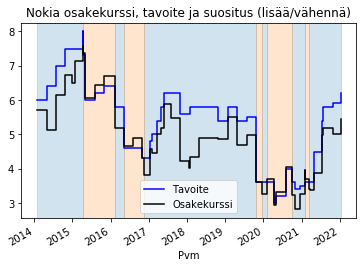

In [10]:
fig, ax = plt.subplots()
# Plot the stock and target price
df_stock.set_index('Pvm')[['Tavoite', 'Osakekurssi']].plot(ax=ax, drawstyle='steps-post', color=['blue', 'black'])
# Calculate the uniform intervals when stock is bought or sold
df_stock['N'] = (df_stock['Salkussa'] != df_stock['Salkussa'].shift(1)).cumsum() - 1
intervals = df_stock[df_stock['N'] > 0].groupby('N').apply(lambda df_stock: pd.Series({
    'PvmEdellinen' : df_stock['PvmEdellinen'].min(), 
    'Pvm'          : df_stock['Pvm'].max(), 
    'Salkussa'     : df_stock['Salkussa'].max(),
}))
# Plot the intervals
from matplotlib.dates import date2num
for (x1, x2) in zip(date2num(intervals.loc[intervals['Salkussa'], 'PvmEdellinen']), 
                    date2num(intervals.loc[intervals['Salkussa'], 'Pvm'])):
    ax.axvspan(xmin = x1, xmax = x2, color = 'tab:blue', alpha=0.2)
for (x1, x2) in zip(date2num(intervals.loc[~intervals['Salkussa'], 'PvmEdellinen']), 
                    date2num(intervals.loc[~intervals['Salkussa'], 'Pvm'])):
    ax.axvspan(xmin = x1, xmax=x2, color = 'tab:orange', alpha=0.2)
ax.set_title('Nokia osakekurssi, tavoite ja suositus (lisää/vähennä)')

In [11]:
get_statistics(df_stock, key='Indeksi')

Tuotto         0.951049
Pitoaika    2911.000000
CAGR           0.993727
dtype: float64

In [12]:
get_statistics(df_stock, key='Suositus')

Tuotto         2.437720
Pitoaika    2097.000000
CAGR           1.167771
dtype: float64

### All stocks

In [13]:
indeksi = recommendations.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, key='Indeksi'))
inderes = recommendations.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, key='Suositus'))
statistics = indeksi.merge(inderes, on='Osake', suffixes=('_Indeksi', '_Inderes'))
statistics

,Osake,Tuotto_Indeksi,Pitoaika_Indeksi,CAGR_Indeksi,Tuotto_Inderes,Pitoaika_Inderes,CAGR_Inderes
0,Aallon Group,1.335964,1001.0,1.111397,1.301279,615.0,1.169172
1,Admicom,5.322034,1247.0,1.631266,2.541791,217.0,4.802379
2,Ahlstrom-Munksjö,0.808757,1136.0,0.934075,1.046540,680.0,1.024717
3,Aktia Pankki A,1.308977,1073.0,1.095914,1.475240,716.0,1.219221
4,Alexandria Pankkiiriliike,0.980347,96.0,0.927310,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...
134,Vincit,1.409836,1837.0,1.070629,1.415696,1313.0,1.101458
135,Wulff Group,3.443709,1161.0,1.475138,4.094422,738.0,2.008067
136,Wärtsilä B,0.990964,2037.0,0.998375,0.943043,770.0,0.972584
137,YIT,0.937984,1300.0,0.982185,0.735419,494.0,0.796870


In [14]:
(statistics['CAGR_Inderes'] > statistics['CAGR_Indeksi']).value_counts()

True     99
False    40
dtype: int64

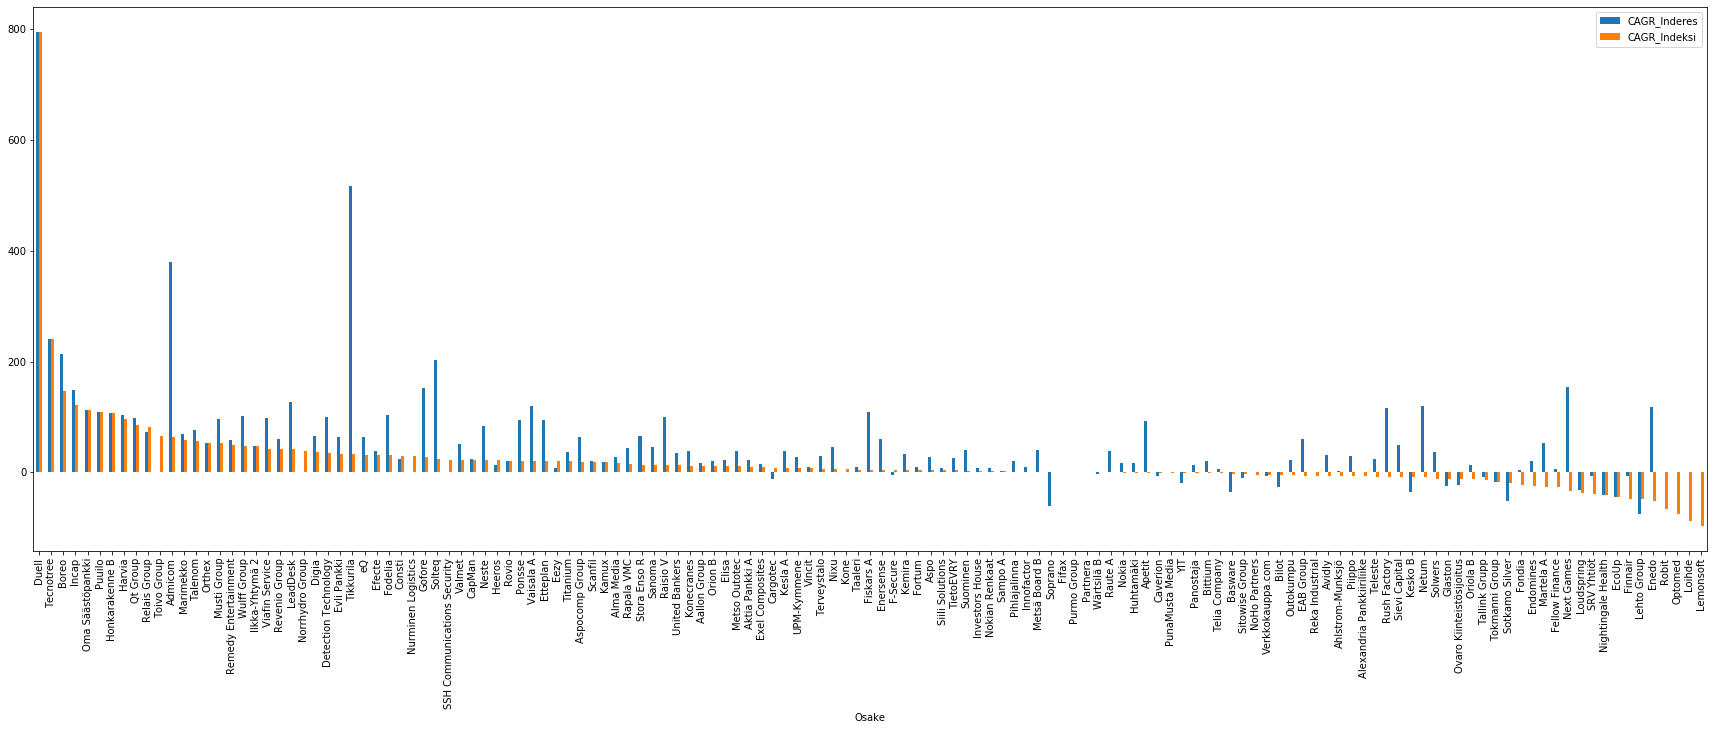

In [15]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
comparison = statistics.set_index('Osake')[['CAGR_Inderes', 'CAGR_Indeksi']].copy()
comparison.sort_values('CAGR_Indeksi', ascending=False, inplace=True)
np.round((comparison-1)*100).plot(ax=ax, kind='bar')

In [16]:
# Inderes yearly return
inderes_avg    = statistics.loc[statistics['Pitoaika_Inderes'] > 0, 'CAGR_Inderes'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Inderes'] / statistics['Pitoaika_Indeksi']).fillna(0)
inderes_mc1 = geom_mean(statistics['CAGR_Inderes'], exposure)
# Another estimate, taking into account when the stock was followed
exposure = (statistics['Pitoaika_Inderes'] / statistics['Pitoaika_Indeksi'].max()).fillna(0)
inderes_mc2 = geom_mean(statistics['CAGR_Inderes'], exposure)

print(inderes_avg, inderes_mc1, inderes_mc2)

1.5419739337069536 1.5680376467731565 1.3858720017086301


In [17]:
# Inderes yearly return
indeksi_avg    = statistics.loc[statistics['Pitoaika_Indeksi'] > 0, 'CAGR_Indeksi'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Indeksi'] / statistics['Pitoaika_Indeksi']).fillna(0)
indeksi_mc1 = geom_mean(statistics['CAGR_Indeksi'], exposure)
# Another estimate, taking into account when the stock was followed
exposure = (statistics['Pitoaika_Indeksi'] / statistics['Pitoaika_Indeksi'].max()).fillna(0)
indeksi_mc2 = geom_mean(statistics['CAGR_Indeksi'], exposure)

print(indeksi_avg, indeksi_mc1, indeksi_mc2)

1.1811901657360238 1.1811901657360229 1.1075742107036597


### Permutation test up to 2020-06-30

In [18]:
cagrs = []
for b in range(100):
    print(b, end=',')
    recommendations['Apina'] = np.random.permutation(recommendations['Suositus'])
    apina = recommendations.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, key='Apina'))
    #cagr  = apina['CAGR'].mean()
    exposure = (apina['Pitoaika'] / indeksi['Pitoaika'].max()).fillna(0)
    cagr = geom_mean(apina['CAGR'], exposure)
    cagrs.append(cagr)
cagrs = np.array(cagrs)
#np.round(cagrs,2)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

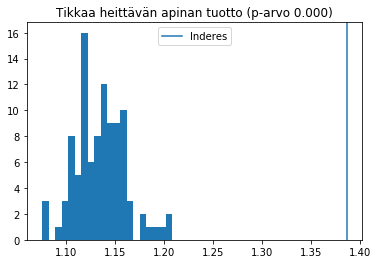

In [19]:
p_arvo = (cagrs >= inderes_mc2).mean()
plt.hist(cagrs, bins=20) #np.arange(1,2,0.05)
plt.axvline(inderes_mc2, label='Inderes')
plt.title('Tikkaa heittävän apinan tuotto (p-arvo %.3f)' % p_arvo)
plt.legend()


In [20]:
print(np.mean(cagrs), np.std(cagrs))
print('Sigmas: % .2f' % ((inderes_mc2 - np.mean(cagrs)) / np.std(cagrs)))

1.1348343646053578 0.025371443989605967
Sigmas:  9.89


### Individual analysts

In [21]:
#recommendations.groupby('Osake', as_)['Analyytikko'].apply(lambda s:s.iloc[-1])
#statistics
indeksi = recommendations.groupby(['Analyytikko', 'Osake']).apply(lambda df: get_statistics(df, key='Indeksi')).reset_index()
inderes = recommendations.groupby(['Analyytikko', 'Osake']).apply(lambda df: get_statistics(df, key='Suositus')).reset_index()
statistics = indeksi.merge(inderes, on=['Analyytikko', 'Osake'], suffixes=('_Indeksi', '_Inderes'))

In [22]:
analyst_performance = dict()
for analyst, statistics_analyst in statistics.groupby('Analyytikko'):
    print(analyst)
    # Analyytikon tuotto
    exposure = (statistics_analyst['Pitoaika_Inderes'] / statistics_analyst['Pitoaika_Indeksi'].max()).fillna(0)
    mc1 = geom_mean(statistics_analyst['CAGR_Inderes'], exposure) if exposure.sum() > 0 else 1.0
    # Indeksin tuotto
    exposure = (statistics_analyst['Pitoaika_Indeksi'] / statistics_analyst['Pitoaika_Indeksi'].max()).fillna(0)
    mc2 = geom_mean(statistics_analyst['CAGR_Indeksi'], exposure) if exposure.sum() > 0 else 1.0
    analyst_performance[analyst] = pd.Series({'Inderes': mc1, 'Indeksi': mc2})
analyst_performance = pd.DataFrame(analyst_performance).transpose()
# Only initials...
analyst_performance.index = [name_FL[0][0]+name_FL[1][0]for name_FL in analyst_performance.index.str.split(" ")]

Aapeli Pursimo
Antti Luiro
Antti Viljakainen
Atte Riikola
Erkki Vesola
Joni Grönqvist
Joonas Korkiakoski
Juha Kinnunen
Matias Arola
Olli Koponen
Olli Vilppo
Pauli Lohi
Petri Gostowski
Petri Kajaani
Sauli Vilén
Thomas Westerholm


Text(0, 0.5, 'Tuotto (%, seuratut osakkeet)')

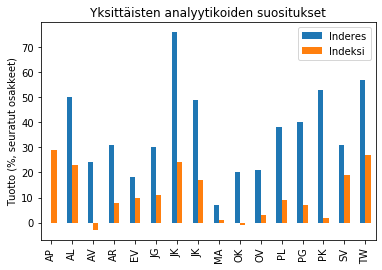

In [23]:
fig, ax = plt.subplots(1,1)
np.round((analyst_performance-1)*100).plot(ax=ax, kind='bar')
ax.set_title("Yksittäisten analyytikoiden suositukset")
ax.set_ylabel("Tuotto (%, seuratut osakkeet)")

### Tuotto osakkeen vaihdon perusteella

In [24]:
import os
# Source: https://www.kauppalehti.fi/porssi/kurssit/XHEL/historia/2021-12-31
#         https://www.kauppalehti.fi/porssi/kurssit/FNFI/historia/2021-12-31
market = pd.read_csv(os.path.join('päätöskurssit', 'XHEL_päätöskurssit_2021-12-31.csv'), sep=';', decimal=',')
stocks_all = list(market.sort_values('Vaihto €', ascending=False)['Osake'])
stocks_25, stocks_large, stocks_medium, stocks_small = stocks_all[:25], stocks_all[0:40], stocks_all[40:80], stocks_all[80:]

In [25]:
market = pd.read_csv(os.path.join('päätöskurssit', 'FNFI_päätöskurssit_2021-12-31.csv'), sep=';', decimal=',')
stocks_fn = list(market.sort_values('Vaihto €', ascending=False)['Osake'])

In [26]:
stock_category = pd.DataFrame([(stock, "omxh25*") for stock in stocks_25] + 
                              [(stock, "largecap") for stock in stocks_large] + 
                              [(stock, "midcap") for stock in stocks_medium] +
                              [(stock, "smallcap") for stock in stocks_small] +
                              [(stock, "fn") for stock in stocks_fn],
                              columns=["Osake", "Kategoria"])
statistics = statistics.merge(stock_category, on="Osake")

In [27]:
category_performance = dict()
for category, statistics_category in statistics.groupby('Kategoria'):
    print(category)
    # Analyytikon tuotto
    exposure = (statistics_category['Pitoaika_Inderes'] / statistics_category['Pitoaika_Indeksi'].max()).fillna(0)
    mc1 = geom_mean(statistics_category['CAGR_Inderes'], exposure) if exposure.sum() > 0 else 1.0
    # Indeksin tuotto
    exposure = (statistics_category['Pitoaika_Indeksi'] / statistics_category['Pitoaika_Indeksi'].max()).fillna(0)
    mc2 = geom_mean(statistics_category['CAGR_Indeksi'], exposure) if exposure.sum() > 0 else 1.0
    category_performance[category] = pd.Series({'Inderes': mc1, 'Indeksi': mc2})
category_performance = pd.DataFrame(category_performance).transpose()
category_performance = category_performance.loc[["omxh25*", "largecap", "midcap", "smallcap", "fn"],]

fn
largecap
midcap
omxh25*
smallcap


In [28]:
category_performance

,Inderes,Indeksi
omxh25*,1.210535,1.084723
largecap,1.282146,1.102074
midcap,1.426498,1.120083
smallcap,1.327948,1.091980
fn,1.535067,1.130938


Text(0, 0.5, 'Tuotto (%, kategorian osakkeet)')

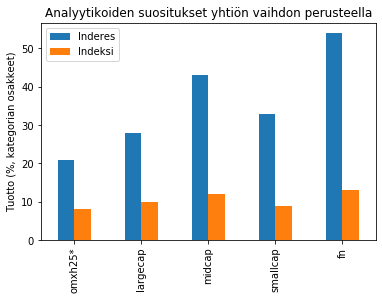

In [29]:
fig, ax = plt.subplots(1,1)
np.round((category_performance-1)*100).plot(ax=ax, kind='bar')
ax.set_title("Analyytikoiden suositukset yhtiön vaihdon perusteella")
ax.set_ylabel("Tuotto (%, kategorian osakkeet)")

### All stocks up to 2020-06-30

In [30]:
limit = pd.Timestamp('2020-06-30')
recommendations_2020Q2 = recommendations.loc[recommendations['Pvm'] <= limit,].copy()

In [31]:
indeksi = recommendations_2020Q2.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, key='Indeksi'))
inderes = recommendations_2020Q2.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, key='Suositus'))
statistics = indeksi.merge(inderes, on='Osake', suffixes=('_Indeksi', '_Inderes'))

In [32]:
(statistics['CAGR_Inderes'] > statistics['CAGR_Indeksi']).value_counts()

True     77
False    37
dtype: int64

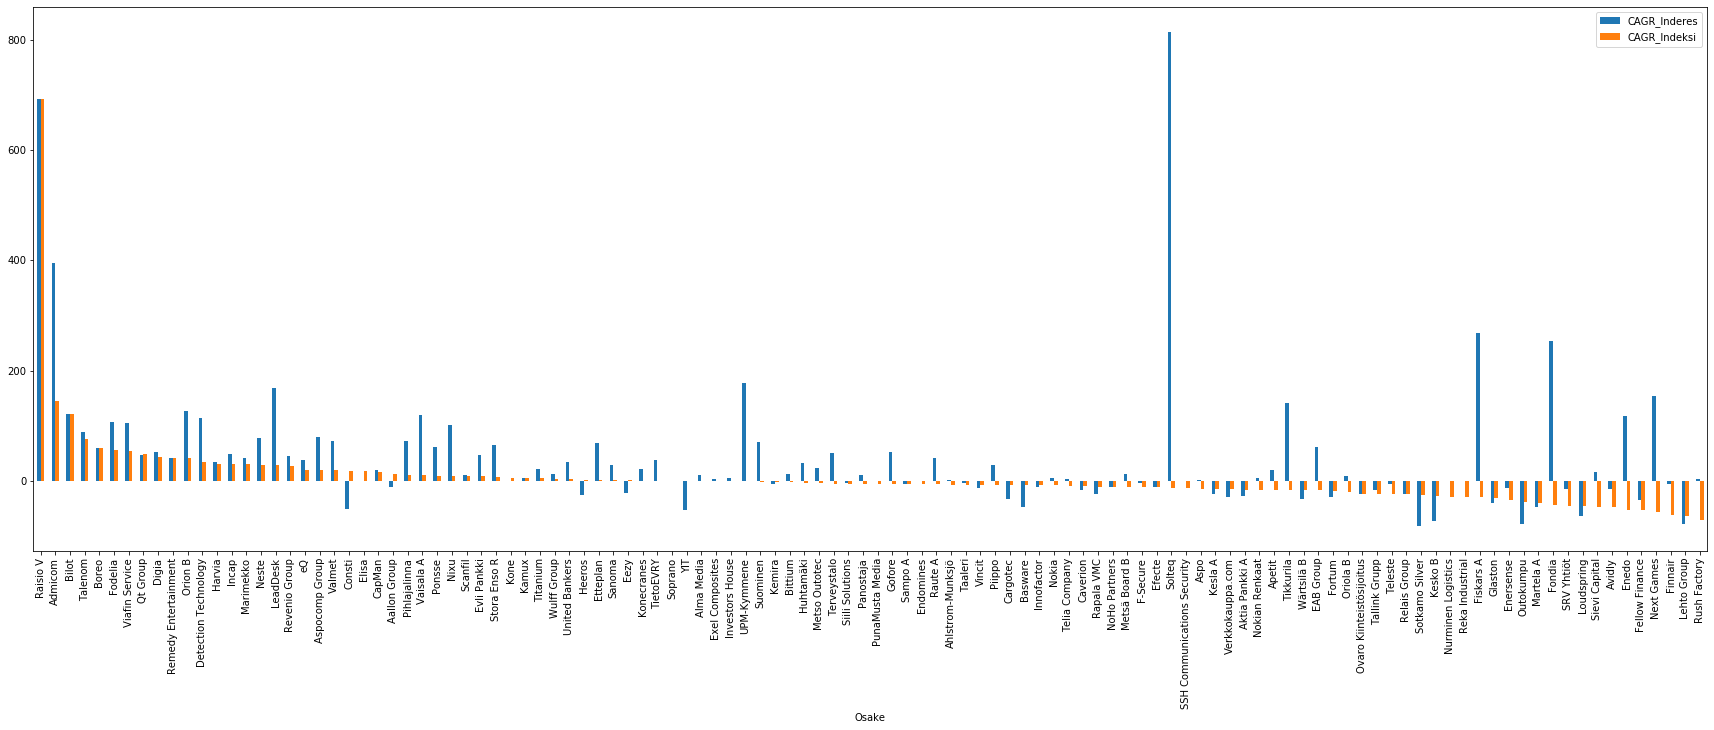

In [33]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
comparison = statistics.set_index('Osake')[['CAGR_Inderes', 'CAGR_Indeksi']].copy()
comparison.sort_values('CAGR_Indeksi', ascending=False, inplace=True)
np.round((comparison-1)*100).plot(ax=ax, kind='bar')

In [40]:
recommendations_2020Q2.loc[recommendations_2020Q2['Osake'] == "Solteq",].head()

,Pvm,Suositus,Tavoite,Osakekurssi,Analyytikko,Osake,Indeksi,PvmEdellinen,Tuotto,Pitoaika,Salkussa,Apina
2427,2017-02-20,Vähennä,1.60,1.69,Joni Grönqvist,Solteq,Lisää,NaT,1.000000,0.0,False,Lisää
2428,2017-04-24,Vähennä,1.70,1.71,Joni Grönqvist,Solteq,Lisää,2017-02-20,1.011834,63.0,False,Lisää
2429,2017-07-12,Lisää,1.80,1.62,Joni Grönqvist,Solteq,Lisää,2017-04-24,0.947368,79.0,False,Vähennä
2430,2017-07-18,Vähennä,1.75,1.68,Joni Grönqvist,Solteq,Lisää,2017-07-12,1.037037,6.0,True,Lisää
2431,2017-09-06,Vähennä,1.75,1.73,Joni Grönqvist,Solteq,Lisää,2017-07-18,1.029762,50.0,False,Lisää


In [34]:
# Inderes yearly return
inderes_avg    = statistics.loc[statistics['Pitoaika_Inderes'] > 0, 'CAGR_Inderes'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Inderes'] / statistics['Pitoaika_Indeksi']).fillna(0)
inderes_mc1 = geom_mean(statistics['CAGR_Inderes'], exposure)
# Another estimate, taking into account when the stock was followed
exposure = (statistics['Pitoaika_Inderes'] / statistics['Pitoaika_Indeksi'].max()).fillna(0)
inderes_mc2 = geom_mean(statistics['CAGR_Inderes'], exposure)

print(inderes_avg, inderes_mc1, inderes_mc2)

1.4318207958868716 1.3717882397622783 1.2016684821315353


In [35]:
# Inderes yearly return
indeksi_avg    = statistics.loc[statistics['Pitoaika_Indeksi'] > 0, 'CAGR_Indeksi'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Indeksi'] / statistics['Pitoaika_Indeksi']).fillna(0)
indeksi_mc1 = geom_mean(statistics['CAGR_Indeksi'], exposure)
# Another estimate, taking into account when the stock was followed
exposure = (statistics['Pitoaika_Indeksi'] / statistics['Pitoaika_Indeksi'].max()).fillna(0)
indeksi_mc2 = geom_mean(statistics['CAGR_Indeksi'], exposure)

print(indeksi_avg, indeksi_mc1, indeksi_mc2)

1.0381348593854205 1.0381348593854205 0.9713944187315097


### Permutation test

In [36]:
cagrs = []
for b in range(100):
    print(b, end=',')
    recommendations_2020Q2['Apina'] = np.random.permutation(recommendations_2020Q2['Suositus'])
    apina = recommendations_2020Q2.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, key='Apina'))
    #cagr  = apina['CAGR'].mean()
    exposure = (apina['Pitoaika'] / indeksi['Pitoaika'].max()).fillna(0)
    cagr = geom_mean(apina['CAGR'], exposure)
    cagrs.append(cagr)
cagrs = np.array(cagrs)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

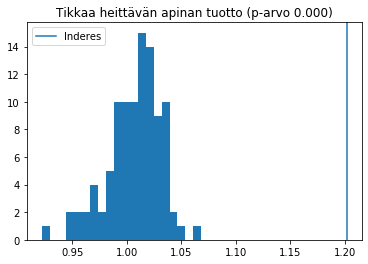

In [37]:
p_arvo = (cagrs >= inderes_mc2).mean()
plt.hist(cagrs, bins=20) #np.arange(1,2,0.05)
plt.axvline(inderes_mc2, label='Inderes')
plt.title('Tikkaa heittävän apinan tuotto (p-arvo %.3f)' % p_arvo)
plt.legend()


In [38]:
print(np.mean(cagrs), np.std(cagrs))
print('Sigmas: % .2f' % ((inderes_mc2 - np.mean(cagrs)) / np.std(cagrs)))

1.0074932052329435 0.024223349681246908
Sigmas:  8.02


In [42]:
len(stocks_small) + 80

144